<a href="https://colab.research.google.com/github/ManditjyotiBorah/Shot-Boundary-Detection-using-DL/blob/main/Final_Year_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install xmltodict torchmetrics pytorch_metric_learning

     |████████████████████████████████| 332 kB 12.6 MB/s 
     |████████████████████████████████| 106 kB 41.9 MB/s 


# Imports

In [ ]:
import cv2
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
from skimage.feature import hog
import os
import random
from PIL import Image
import json
from json import JSONEncoder
from torchmetrics import PrecisionRecallCurve

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('GPU')
else:
  device = torch.device('cpu')
  print('CPU')

GPU


In [ ]:
class Dataset(Dataset):
  def __init__(self, dataset, transform = None):
    self.df = dataset
    self.transform = transform
    self.len = len(dataset)

  def __len__(self):
    return self.len
  
  def __getitem__(self, idx):
    img1 = self.df[idx][0]
    img2 = self.df[idx][1]
    img1 = Image.fromarray(np.uint8(img1)).convert('RGB')
    img2 = Image.fromarray(np.uint8(img2)).convert('RGB')
    target = torch.tensor(1.0 - self.df[idx][2])
    if self.transform:
      img1 = self.transform(img1)
      img2 = self.transform(img2)
    return img1, img2, target

In [ ]:
dataset = []

for files in os.listdir("/content/drive/MyDrive/Datasets/JSONs"):
  with open("/content/drive/MyDrive/Datasets/JSONs/"+files) as fp:
    obj = json.load(fp)
    for i in range(len(obj)):
      img1 = np.asarray(json.loads(obj[i]["image1"]))
      img2 = np.asarray(json.loads(obj[i]["image2"]))
      target = obj[i]["target"]
      dataset.append([img1, img2, target])
  print(files)

anni005.mpg.json
anni009.mpg.json
BOR03.mpg.json
BOR08.mpg.json
NAD57.mpg.json
senses111.mpg.json
NAD31.mpg.json
NAD33.mpg.json


## Train-Test-Split

In [ ]:
len(dataset)

2381

In [ ]:
train = round(0.8 * len(dataset))
test = round(0.2 * len(dataset))
validation = round(0.2 * train)
train -= validation
print(len(dataset), train, validation, test)

2381 1524 381 476


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size = 0.2, shuffle = True)
train, val = train_test_split(train, test_size = 0.2, shuffle = True)
print(len(train), len(val), len(test))

1523 381 477


In [ ]:
mean = [0.5, 0.5, 0.5]
std = [0.229, 0.224, 0.225]
composed = transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.ConvertImageDtype(torch.float),
                               transforms.Normalize(mean, std)])

train_dataset = Dataset(dataset = train, transform = composed)
val_dataset = Dataset(dataset = val, transform = composed)
test_dataset = Dataset(dataset = test, transform = composed)

In [ ]:
batchSize = 16
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batchSize)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset)

# Model 

In [ ]:
model_ft = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model_ft.children())[:-1])

In [ ]:
for params in model.parameters():
  params.requires_grad = False

In [ ]:
model[7][2] = nn.Sequential(
      nn.Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False),
      nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
      nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False),
      nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(inplace=True))

model[8] = nn.Sequential(nn.AdaptiveAvgPool2d(output_size=(1, 1)))

model.to(device)

# Model Training

In [ ]:
def cosine_similarity(a, b):
  cos = nn.CosineSimilarity(dim=1, eps=1e-08)
  return cos(a, b)

In [ ]:
def printFormat(a, b, c):
  print('|', '{:^12}'.format(a), '|', '{:^12}'.format(b), '|', '{:^12}'.format(c), '|')
  print('+--------------+--------------+--------------+')

In [ ]:
def Test(dataset, loader, inp_model, thresh):
  correct = 0
  predTest = []
  actualTest = []
  
  for img1, img2, target in loader:
    inp_model.eval()
    img1 = img1.to(device)
    img2 = img2.to(device)
    target = target.to(device)

    FV1 = torch.squeeze(inp_model(img1))
    FV2 = torch.squeeze(inp_model(img2))

    FV1 = FV1.view(-1, 2048)
    FV2 = FV2.view(-1, 2048)

    resnet_sim = cosine_similarity(FV1, FV2)
    resnet_diff = 1 - resnet_sim

    for i in range(len(target)):
      # predicted similar
      if(resnet_diff[i].item() >= thresh):
        correct += (target[i].item() == 1.0)
      else:
        correct += (target[i].item() == 0.0)

      predTest.append(resnet_diff[i].item())
      actualTest.append(target[i].item())

  output = {
      "prediction": predTest,
      "actual": actualTest,
      "accuracy": correct / len(dataset)
  }

  return output

In [ ]:
def optimalf1(pred, actual):
  pr_curve = PrecisionRecallCurve(pos_label=1)
  precision, recall, thresholds = pr_curve(torch.tensor(pred), torch.tensor(actual))
  fscore = (2*precision*recall)/(precision+recall)
  ix = torch.argmax(fscore)
  output = {
      "f1": fscore[ix].item(),
      "recall": recall[ix].item(),
      "precision": precision[ix].item(),
      "threshold": thresholds[ix].item()
  }
  return output

In [ ]:
# criterion = nn.BCELoss()
# from pytorch_metric_learning import losses
# criterion = losses.ContrastiveLoss(pos_margin=1, neg_margin=0)
criterion = nn.BCELoss()
optim = torch.optim.Adam([params for params in model.parameters() if params.requires_grad == True], lr = 1e-3)

epochs = 5
batchno = 0


# printFormat('Batch_no', 'Actual_Sim', 'Cosine_Sim')

for epoch in range(epochs):
  pred = []
  actual = []
  ######################################################################
  #################### TRAINING MODEL ##################################
  ######################################################################
  correct = 0
  for img1, img2, target in train_loader:
    # resnet model
    model.train()
    img1 = img1.to(device)
    img2 = img2.to(device)
    target = target.to(device)

    optim.zero_grad()

    FV1 = torch.squeeze(model(img1))
    FV2 = torch.squeeze(model(img2))

    resnet_sim = cosine_similarity(FV1, FV2)
    resnet_diff = 1.0 - resnet_sim
    
    # Precision-Recall curve
    for i in range(len(target)):
      actual.append(target[i].item())
      pred.append(resnet_diff[i].item())
      
    if batchno % 20 == 0:
      print('/', end='')

    loss = criterion(resnet_diff, target)
    
    loss.backward()
    optim.step()
    
    batchno += batchSize


  trainR = optimalf1(pred, actual)

  ######################################################################
  ############# Testing Model ##########################################
  ######################################################################
  testOutput = Test(test_dataset, test_loader, model, trainR["threshold"])
  testR = optimalf1(testOutput["prediction"], testOutput["actual"])


  print(' ')
  print('+++++++++++++++++++++++++++++++++++++++++++++++++++++')
  print(f'Epoch{epoch+1}: Training Results')
  print('+++++++++++++++++++++++++++++++++++++++++++++++++++++')
  print('Recall: ', trainR["recall"])
  print('Precision ', trainR["precision"])
  print('Threshold: ', trainR["threshold"])
  print('F1-Score: ', trainR["f1"])
  print('+++++++++++++++++++++++++++++++++++++++++++++++++++++')
  print('+++++++++++++++++++++++++++++++++++++++++++++++++++++')
  print('Testing Results: ')
  print('Recall: ', testR["recall"])
  print('Precision ', testR["precision"])
  print('Threshold: ', testR["threshold"])
  print('+++++++++++++++++++++++++++++++++++++++++++++++++++++')
  print('+++++++++++++++++++++++++++++++++++++++++++++++++++++')

////////////////////

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


 
+++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch1: Training Results
+++++++++++++++++++++++++++++++++++++++++++++++++++++
Recall:  0.9352707862854004
Precision  0.9147287011146545
Threshold:  0.09358012676239014
F1-Score:  0.9248857498168945
+++++++++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++++++++++++++++++++++
Testing Results: 
Recall:  0.9793388247489929
Precision  0.9556451439857483
Threshold:  0.05341988801956177
+++++++++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++++++++++++++++++++++
/////////////////// 
+++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch2: Training Results
+++++++++++++++++++++++++++++++++++++++++++++++++++++
Recall:  0.9696168899536133
Precision  0.9670619368553162
Threshold:  0.1630784273147583
F1-Score:  0.9683377146720886
+++++++++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++++++++++++++++++++++
Testing Results: 
Recall:  0.97933882474

In [ ]:
for ac,pre in zip(actual,pred):
  if ac==1.0:
    print(ac,pre)

In [ ]:
# Training Loss Curve
plt.figure(figsize=(10, 6))
plt.title('Training Loss Curvve')
plt.xlabel('Traning Loss')
plt.ylabel('Epochs')
plt.plot(Loss)

In [ ]:

pr_curve = PrecisionRecallCurve(pos_label=1)
precision, recall, thresholds = pr_curve(torch.tensor(pred), torch.tensor(actual))

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
maxf1 = 0.0
prec = 0.0
rec = 0.0
thresh = 0.0
for i in range(len(precision)-1):
  curf1 = 2 * precision[i].item() * recall[i].item() / (precision[i].item() + recall[i].item())
  if(curf1 > maxf1):
    maxf1 = curf1
    prec = precision[i].item()
    rec = recall[i].item()
    thresh = thresholds[i].item()
print(maxf1, prec, rec, thresh)

0.8558897345970062 0.8248792290687561 0.8893229365348816 0.7920545935630798


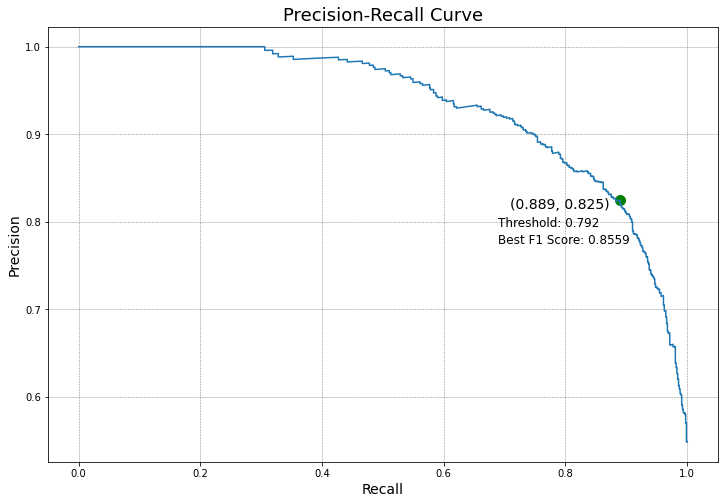

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Precision-Recall Curve', fontsize="18")
plt.xlabel('Recall', fontsize="14")
plt.ylabel('Precision', fontsize="14")
plt.plot(recall, precision)
plt.scatter([rec], [prec], color="green", s=100)
plt.text(rec-0.18, prec-0.01, '({}, {})'.format(round(rec, 3), round(prec, 3)), fontsize="14")
plt.text(rec-0.2, prec-0.03, f"Threshold: {round(thresh, 3)}", fontsize="12")
plt.text(rec-0.2, prec-0.05, f"Best F1 Score: {round(maxf1, 4)}", fontsize="12")
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

0.8349942210374337 0.8784596920013428 0.9505208134651184


In [ ]:
result = optimalf1(predTest, actualTest)
# print(result)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
zero = 0
one = 0
corone = 0
corzero = 0

for act, pre in zip(actualTest, predTest):
  if act == 0.0:
    zero += 1
    if pre < thresh:
      corzero += 1
  else:
    one += 1
    if pre >= thresh:
      corone += 1

print(zero, corzero)
print(one, corone)



246 182
231 228


# Save Trained Model

In [ ]:
model_save_name = 'sbd-resnet50-v2.pt'
path = F"/content/drive/MyDrive/Datasets/{model_save_name}" 
torch.save(model.state_dict(), path)

# Testing on New Video

In [ ]:
def readImg(cap):
  ret, frame = cap.read()
  frame = cv2.resize(frame, (224, 224), fx = 0, fy = 0, interpolation = cv2.INTER_CUBIC)
  img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  return img

def readVideo(video_path):
  cap = cv2.VideoCapture(video_path)
  frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  
  print(frameCount)

  images = []
  prevImg = readImg(cap)
  for i in range(frameCount):
    nextImg = readImg(cap)
    images.append([prevImg, nextImg, 1.0])
    prevImg = nextImg
  
  cap.release()
  return images

In [ ]:
tv2001_video_root = "/content/drive/My Drive/Datasets/Videos/Trecvid 2001 video data"
tv2007_video_root = "/content/drive/MyDrive/Datasets/Videos/Trecvid 2001 video data/TRECVID 2007"
tv2001_annot_root = "/content/drive/My Drive/Datasets/Annotations/sbref01"
tv2007_annot_root = "/content/drive/MyDrive/Datasets/Annotations/masterShotRef_train"

images = readVideo(os.path.join(tv2001_video_root, "anni006.mpg"))

In [ ]:
model_save_name = 'sbd-resnet50-v2.pt'
load_path = F"/content/drive/MyDrive/Datasets/{model_save_name}"

load_model = models.resnet50(pretrained = True)
load_model = torch.nn.Sequential(*list(load_model.children())[:-1])

load_model[7][2] = nn.Sequential(
      nn.Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False),
      nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
      nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False),
      nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(inplace=True))

load_model[8] = nn.Sequential(nn.AdaptiveAvgPool2d(output_size=(1, 1)))

load_model.load_state_dict(torch.load(load_path))
load_model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
pre, act, acc = Test(test_loader, load_model, 0.8)
print(acc)

In [ ]:
for p, a in zip(pre, act):
  if(a == 0.0):
    print(p, a)

25 0.28250652551651
48 0.3300294280052185
214 0.4090454578399658
276 0.6116180419921875
348 0.5230658650398254
412 0.5603476762771606
529 0.6801382303237915
545 0.2997545599937439
580 0.6598718166351318
701 0.5067139267921448
864 0.7916626930236816


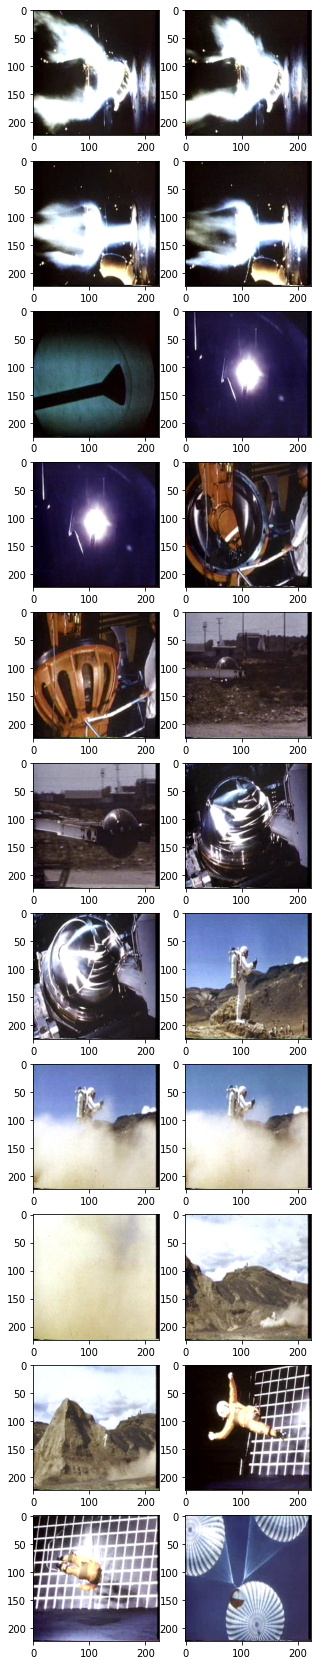

In [ ]:
cnt = 10
n = 10
f, axarr = plt.subplots(n+1, 2, figsize=(5, cnt*3))

for i, (img1, img2, _) in enumerate(images):
  load_model.eval()

  mean = [0.5, 0.5, 0.5]
  std = [0.229, 0.224, 0.225]
  composed = transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.ConvertImageDtype(torch.float),
                               transforms.Normalize(mean, std)])
  
  img1t = composed(Image.fromarray(np.uint8(img1)).convert('RGB'))
  img2t = composed(Image.fromarray(np.uint8(img2)).convert('RGB'))

  img1t = img1t.view(-1, 3, 224, 224)
  img2t = img2t.view(-1, 3, 224, 224)

  img1t = img1t.to(device)
  img2t = img2t.to(device)

  FV1 = torch.squeeze(load_model(img1t))
  FV2 = torch.squeeze(load_model(img2t))

  FV1 = FV1.view(-1, 2048)
  FV2 = FV2.view(-1, 2048)

  resnet_diff=1-cosine_similarity(FV1, FV2)

  if(resnet_diff.item() > 0.28):
    print(i, resnet_diff.item())
    axarr[n-cnt][0].imshow(img1)
    axarr[n-cnt][1].imshow(img2)
    if cnt == 0:
      break
    cnt -= 1

# Load Saved Model

In [ ]:
from torchmetrics import PrecisionRecallCurve
pr_curve = PrecisionRecallCurve(pos_label=1)
precision, recall, thresholds = pr_curve(torch.tensor(pred), torch.tensor(actual))

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


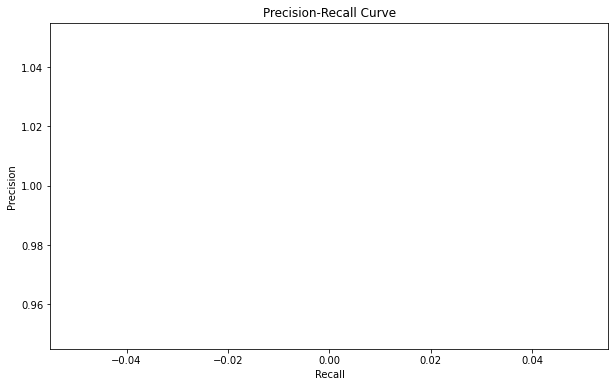

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall, precision)

In [ ]:
cnt = 0
for i in range(len(pred)):
  if(actual[i] == 0.0):
    print(pred[i], actual[i])
    if(cnt > 100):
      break
    cnt += 1

0.9903749227523804 0.0
0.9811328649520874 0.0
0.9819972515106201 0.0
0.9816336631774902 0.0
0.9640860557556152 0.0
0.9824292063713074 0.0
0.9743204116821289 0.0
0.9800810217857361 0.0
0.9898430705070496 0.0
0.9874083399772644 0.0
0.9777175784111023 0.0
0.9345813989639282 0.0
0.9803188443183899 0.0
0.9728167057037354 0.0
0.9951338171958923 0.0
0.9896398186683655 0.0
0.9858046174049377 0.0
0.9918534755706787 0.0
0.985291600227356 0.0
0.9869146943092346 0.0
0.9772301912307739 0.0
0.9631932377815247 0.0
0.991730272769928 0.0
0.9972543120384216 0.0
0.9819170832633972 0.0
0.8077396154403687 0.0
0.9471303224563599 0.0
0.9905252456665039 0.0
0.9386996626853943 0.0
0.9460552930831909 0.0
0.9040957093238831 0.0
0.8971796035766602 0.0
0.9698930382728577 0.0
0.9989610314369202 0.0
0.9554932713508606 0.0
0.9876322746276855 0.0
0.9329080581665039 0.0
0.9080775380134583 0.0
0.9981296062469482 0.0
0.9927294254302979 0.0
0.9674789309501648 0.0
0.9709632396697998 0.0
0.9971545934677124 0.0
0.99954020977

In [ ]:
f1score = 0.0
maxprec = 0.0
maxrec = 0.0
thresh = 0.0

for i in range(len(precision)):
  if(i == len(precision)-1):
    break
  rec = recall[i]
  prec = precision[i]

  currentf1 = 2 * rec * prec / (rec + prec)
  if(currentf1 > f1score):
    f1score = currentf1
    maxprec = prec
    maxrec = rec
    thresh = thresholds[i]

print('F1 Score: ', f1score)
print('Recall: ', maxrec)
print('Precision: ', maxprec)
print('Threshold: ', thresh)

F1 Score:  tensor(0.9079)
Recall:  tensor(1.)
Precision:  tensor(0.8314)
Threshold:  tensor(0.1648)


In [ ]:
correct = 0
for img1, img2, target in val_loader:
    model.eval()
    img1 = img1.to(device)
    img2 = img2.to(device)
    target = target.to(device)

    FV1 = torch.squeeze(model(img1))
    FV2 = torch.squeeze(model(img2))

    similarity = cosine_similarity(FV1, FV2)

    for i in range(len(target)):
      # predicted similar
      if(similarity[i].item() >= thresh):
        correct += (abs(target[i].item() - 1) < 1e-8)
      else:
        correct += (target[i].item() < 1e-8)

accuracy = correct/len(val_dataset)
print(accuracy)

0.8295880149812734


In [ ]:
correct = 0
x = []
y = []

for img1, img2, target in val_loader:
    model.eval()
    img1 = img1.to(device)
    img2 = img2.to(device)
    target = target.to(device)

    FV1 = torch.squeeze(model(img1))
    FV2 = torch.squeeze(model(img2))

    similarity = cosine_similarity(FV1, FV2)

    for i in range(len(target)):
      # predicted similar
      if(similarity[i].item() >= 0.95):
        correct += (abs(target[i].item() - 1) < 1e-8)
      else:
        correct += (target[i].item() < 1e-8)

      x.append(similarity[i].item())
      y.append(target[i].item())

accuracy = correct/len(val_dataset)
print(accuracy)

0.7710144927536232


In [ ]:
zerocnt = 0
onecnt = 0

for i in range(len(x)):
  if(y[i] == 0.0):
    zerocnt += 1
  else:
    onecnt += 1

print(onecnt, zerocnt)

0 2070


In [ ]:
for i in range(len(x)):
  if(y[i] == 0.0):
    print(x[i], y[i])

0.6659016609191895 0.0
0.863439679145813 0.0
0.832507848739624 0.0
0.9315276145935059 0.0
0.7512177228927612 0.0
0.9699816107749939 0.0
0.6654362678527832 0.0
0.9999613761901855 0.0
0.7398648262023926 0.0
0.5221517086029053 0.0
0.9877409934997559 0.0
0.8021383881568909 0.0
0.9494652152061462 0.0
0.9100050926208496 0.0
0.8464953303337097 0.0
0.29546433687210083 0.0
0.9452666640281677 0.0
0.9455363154411316 0.0
0.47359901666641235 0.0
0.4113268554210663 0.0
0.9078158736228943 0.0
0.9732766151428223 0.0
0.5958644151687622 0.0
0.7500995993614197 0.0
0.47891509532928467 0.0
0.9962738156318665 0.0
0.5542497038841248 0.0
0.8374221324920654 0.0
0.7946431040763855 0.0
0.4328555762767792 0.0
0.9954911470413208 0.0
0.9099501967430115 0.0
0.809359073638916 0.0
0.9600764513015747 0.0
0.15930771827697754 0.0
0.8380632996559143 0.0
0.6694273948669434 0.0
0.8591206073760986 0.0
0.7329995632171631 0.0
0.4707447588443756 0.0
0.8548954725265503 0.0
0.04859393835067749 0.0
0.8540595769882202 0.0
0.9344721

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(TrainingLoss)

In [ ]:
def HOG(img):
  fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=True)
  plt.imshow(hog_image, cmap="gray")

# model[7][1] = nn.Sequential(
#     nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
#     nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#     nn.ReLU(inplace=True),
#     nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
#     nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#     nn.ReLU(inplace=True))

# model[8] = nn.Sequential(nn.AdaptiveAvgPool2d(output_size=(1, 1)))

# Inception
# model.fc = nn.Linear(in_features=2048, out_features=1000, bias=True)

# Experimentations

In [ ]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Datasets/Videos/Trecvid 2001 video data/Trecvid 2001 video data/anni005.mpg')

In [ ]:
imgg = []
i = 0
while(cap.isOpened() and i < 1060):
  imgg.append(readImg(cap))
  i += 1

In [ ]:
for i in range(1037, 1058):
  plt.figure()
  plt.imshow(imgg[i])

In [ ]:
from torchmetrics import PrecisionRecallCurve
pred = torch.tensor([0, 1, 2, 3, 3, 4])
target = torch.tensor([0, 1, 1, 0, 0, 1])
pr_curve = PrecisionRecallCurve(pos_label=1)
precision, recall, thresholds = pr_curve(pred, target)
print(precision)
# tensor([0.6667, 0.5000, 0.0000, 1.0000])
print(recall)
# tensor([1.0000, 0.5000, 0.0000, 0.0000])
print(thresholds)
# tensor([1, 2, 3])